In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from model import Autoencoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
torch.cuda.empty_cache()
train_X = pd.read_csv("data/train_X.csv").values
val_X   = pd.read_csv("data/val_X.csv").values
X_test  = pd.read_csv("data/X_test.csv").values
y_test  = pd.read_csv("data/y_test.csv").values.squeeze()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32))
val_tensor = torch.tensor(val_X, dtype=torch.float32).to(device)
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, pin_memory=True)

In [ ]:
model = Autoencoder(18).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 50
best_val_loss = float('inf')
patience = 3
wait = 0

for epoch in range(epochs):
    start_time = time.time()

    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs = batch[0].to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    with torch.no_grad():
        val_output = model(val_tensor)
        val_loss = criterion(val_output, val_tensor)

    duration = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} | Time: {duration:.2f}s | Train Loss: {train_loss:.6f} | Val Loss: {val_loss.item():.6f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

Epoch 1/50 | Time: 29.15s | Train Loss: 0.556525 | Val Loss: 0.316967
Epoch 2/50 | Time: 29.70s | Train Loss: 0.293312 | Val Loss: 0.277267
Epoch 3/50 | Time: 29.36s | Train Loss: 0.252454 | Val Loss: 0.217742
Epoch 4/50 | Time: 28.38s | Train Loss: 0.202349 | Val Loss: 0.196275
Epoch 5/50 | Time: 29.58s | Train Loss: 0.193893 | Val Loss: 0.191530
Epoch 6/50 | Time: 28.43s | Train Loss: 0.186124 | Val Loss: 0.182735
Epoch 7/50 | Time: 28.32s | Train Loss: 0.179957 | Val Loss: 0.176918
Epoch 8/50 | Time: 28.14s | Train Loss: 0.173487 | Val Loss: 0.171327
Epoch 9/50 | Time: 28.22s | Train Loss: 0.170506 | Val Loss: 0.169826
Epoch 10/50 | Time: 28.59s | Train Loss: 0.169086 | Val Loss: 0.168240
Epoch 11/50 | Time: 29.15s | Train Loss: 0.166985 | Val Loss: 0.165518
Epoch 12/50 | Time: 28.79s | Train Loss: 0.163585 | Val Loss: 0.161799
Epoch 13/50 | Time: 28.80s | Train Loss: 0.160904 | Val Loss: 0.160360
Epoch 14/50 | Time: 28.27s | Train Loss: 0.160087 | Val Loss: 0.159887
Epoch 15/50 | T

MAD-based threshold: 0.008555


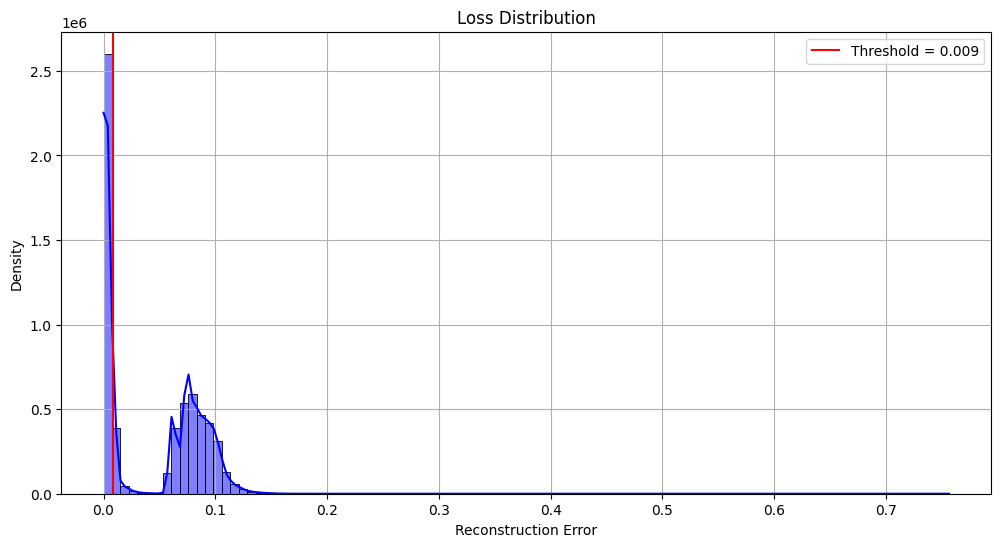

In [ ]:
test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructions = model(test_tensor).cpu().numpy()

reconstruction_errors = np.mean((X_test - reconstructions) ** 2, axis=1)

benign_errors = reconstruction_errors[y_test == 0]
median = np.median(benign_errors)
mad = np.median(np.abs(benign_errors - median))
threshold = median + 3 * mad

print(f"MAD-based threshold: {threshold:.6f}")

plt.figure(figsize=(12, 6))
plt.title("Loss Distribution")

sns.histplot(reconstruction_errors, bins=100, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='-', label=f"Threshold = {threshold:.3f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.xlim(0, 0.2)
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
y_pred = (reconstruction_errors > threshold).astype(int)

print(f"Threshold: {threshold:.6f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Threshold: 0.008555

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8856    0.9393   3066853
           1     0.8974    1.0000    0.9459   3066853

    accuracy                         0.9428   6133706
   macro avg     0.9487    0.9428    0.9426   6133706
weighted avg     0.9487    0.9428    0.9426   6133706

Confusion Matrix:
[[2716077  350776]
 [      0 3066853]]
